In [2]:
# Importar las librerias que se van a usar
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Leemos los datos que se van a utilizar
aapl = pd.read_csv('aapl.csv', sep=';')

# Inspeccionamos los datos que acabamos de importar
aapl.head()

,Trimeste,fecha,Ingresos
0,Q1 1990,12/29/1989,1493
1,Q2 1990,03/30/1990,1346
2,Q3 1990,06/29/1990,1365
3,Q4 1990,09/28/1990,1354
4,Q1 1991,12/28/1990,1676


In [4]:
# Seleccionamos el tipo de calendario y creamos el indice con las fechas
aapl['fecha'] = pd.to_datetime(aapl['fecha'])
aapl = aapl.set_index('fecha')

In [5]:
# Visualizamos los datos
aapl.head()

,Trimeste,Ingresos
fecha,,
1989-12-29,Q1 1990,1493
1990-03-30,Q2 1990,1346
1990-06-29,Q3 1990,1365
1990-09-28,Q4 1990,1354
1990-12-28,Q1 1991,1676


<AxesSubplot:xlabel='fecha'>

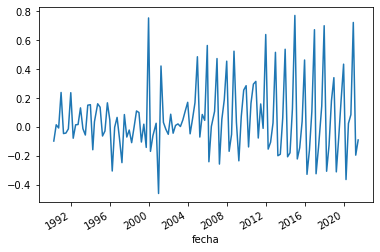

In [6]:
# Visualización de los retornos de los ingresoso
aapl['change']=aapl.Ingresos.pct_change()
aapl.change.plot()

In [7]:
# Convertir datos a trimestrales
aapl_ts = aapl.resample('q').last()
aapl.drop(columns='Trimeste')

,Ingresos,change
fecha,,
1989-12-29,1493,NaN
1990-03-30,1346,-0.098459
1990-06-29,1365,0.014116
1990-09-28,1354,-0.008059
1990-12-28,1676,0.237814
...,...,...
2020-06-27,59685,0.023528
2020-09-26,64698,0.083991
2020-12-26,111439,0.722449


In [8]:
# Convertimos los datos en float64 para poder aplicar los modelos
aapl_ts_q = aapl['Ingresos'].astype('float64').to_period('Q').sort_index()
aapl_ts_q.tail()

fecha
2020Q2     59685.0
2020Q3     64698.0
2020Q4    111439.0
2021Q1     89584.0
2021Q2     81434.0
Freq: Q-DEC, Name: Ingresos, dtype: float64

Text(0, 0.5, 'Ventas Apple. Inc')

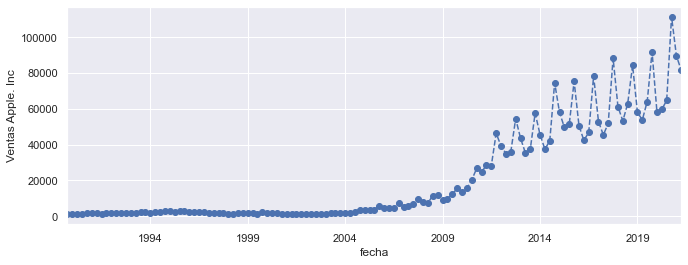

In [10]:
# Vamos a visualizar los datos para ver si son estacionarios en varianza
sns.set(rc={'figure.figsize':(11,4)})
aapl_plt = aapl_ts.Ingresos.plot(marker='o', linestyle='--')
aapl_plt.set_ylabel('Ventas Apple. Inc')

# Los retornos no son estacionarios en varianza

In [11]:
# Transformacion aplicando Logaritmos
from sktime.transformations.series.boxcox import LogTransformer

In [12]:
transformer = LogTransformer()
log_aapl_ts = transformer.fit_transform(aapl_ts_q)
log_aapl_ts.tail()

fecha
2020Q2    10.996836
2020Q3    11.077486
2020Q4    11.621233
2021Q1    11.402932
2021Q2    11.307548
Freq: Q-DEC, Name: Ingresos, dtype: float64

Text(0.5, 1.0, 'Ventas Apple. Inc: Transformation Log')

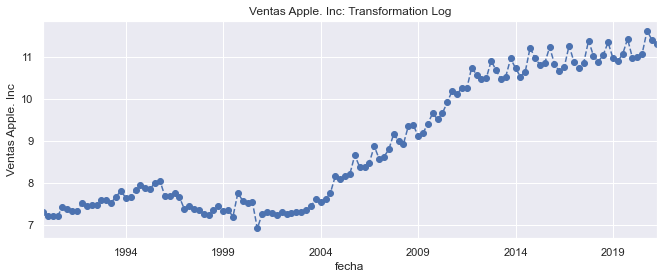

In [13]:
# Visualizamos la tabla con logaritmos
log_aapl_plot = log_aapl_ts.plot(marker='o', linestyle='--')
log_aapl_plot.set_ylabel('Ventas Apple. Inc')
log_aapl_plot.set_title('Ventas Apple. Inc: Transformation Log') 

In [14]:
# Autocorrelacion serie logaritmica
from sktime.utils.plotting import plot_correlations

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

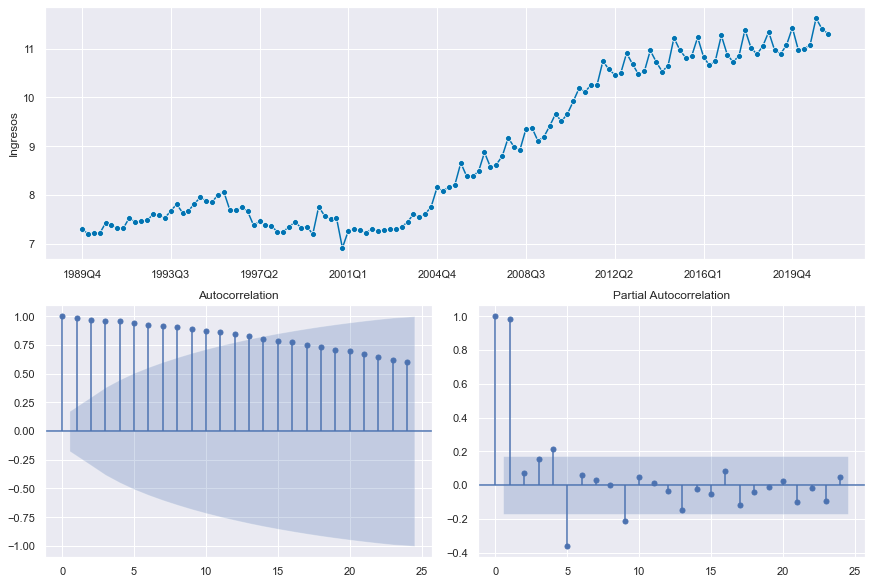

In [15]:
# Visualización de los datos (log)
plot_correlations(log_aapl_ts)

In [17]:
# Funcion dif2erencial
from sktime.transformations.series.difference import Differencer

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

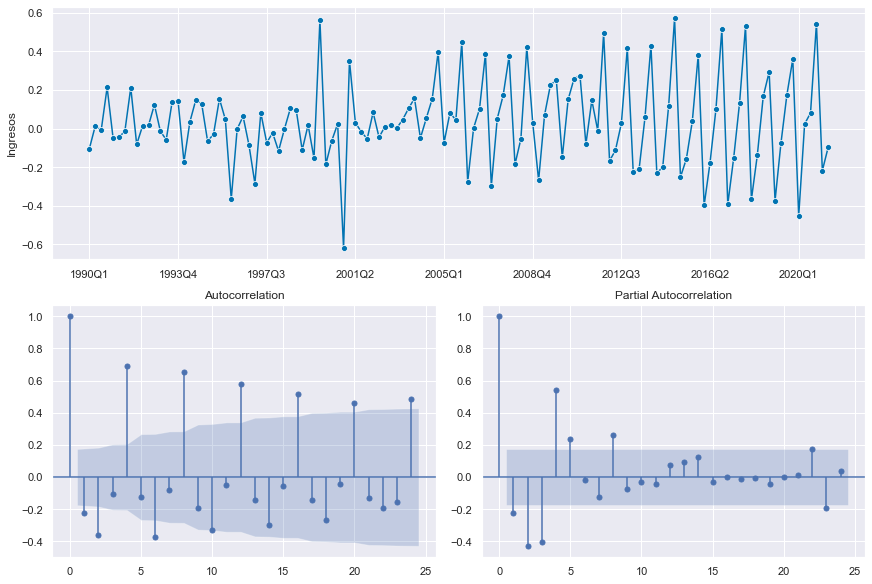

In [18]:
# Aplicar la funcion diferencial
transf_diff = Differencer(lags=[1])
plot_correlations(transf_diff.fit_transform(log_aapl_ts))

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

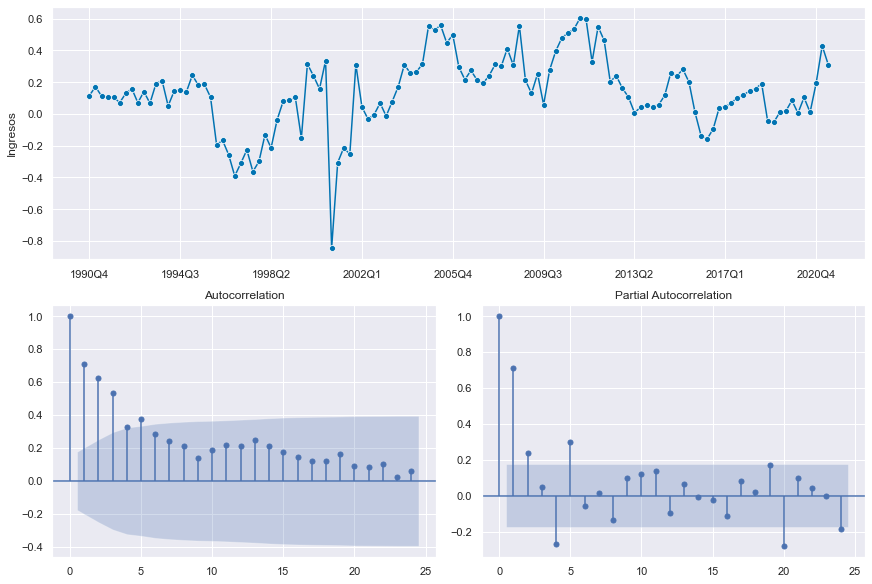

In [19]:
transf_diff = Differencer(lags=[4])
plot_correlations(transf_diff.fit_transform(log_aapl_ts))

(<Figure size 864x576 with 3 Axes>,
 array([<AxesSubplot:ylabel='Ingresos'>,
        <AxesSubplot:title={'center':'Autocorrelation'}>,
        <AxesSubplot:title={'center':'Partial Autocorrelation'}>],
       dtype=object))

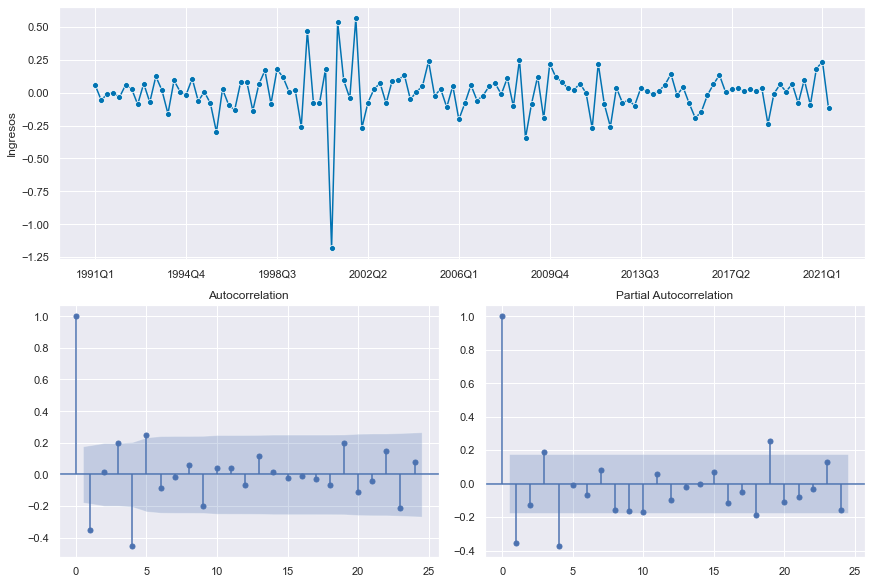

In [20]:
transf_diff = Differencer(lags=[1,4])
plot_correlations(transf_diff.fit_transform(log_aapl_ts))

In [21]:
# Modelo ARIMA
# Prediccion de 8 periodos (h=8) equivalente a 2 años en Qs
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.utils.plotting import plot_series

119 8


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

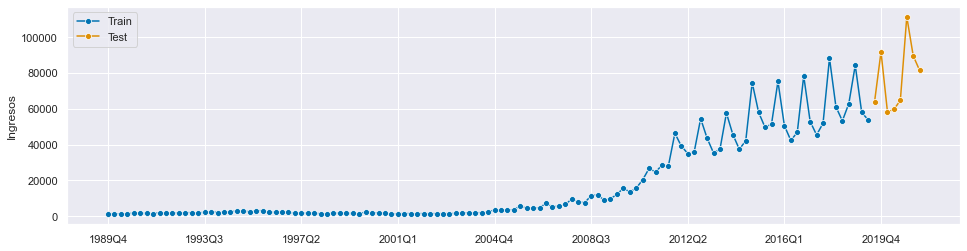

In [22]:
# Seleccionamos el train y test set
y_train, y_test = temporal_train_test_split(y = aapl_ts_q, test_size=8)
log_y_train, log_y_test = temporal_train_test_split(y=log_aapl_ts, test_size=8)
print(y_train.shape[0], y_test.shape[0])
plot_series(y_train, y_test, labels=['Train', 'Test'])

In [23]:
fh = np.arange(len(y_test)) +1
fh

array([1, 2, 3, 4, 5, 6, 7, 8])

In [24]:
# Computamos el AUTOARIMA
from sktime.forecasting.arima import AutoARIMA
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_y_train)
print(forecaster.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  119
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 4)   Log Likelihood                  58.360
Date:                           Tue, 02 Nov 2021   AIC                           -108.720
Time:                                   11:46:53   BIC                            -97.637
Sample:                                        0   HQIC                          -104.220
                                           - 119                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3363      0.089     -3.795      0.000      -0.510      -0.163
ar.S.L4        0.9156      0.062     14.822

In [25]:
# SARIMAX(0, 1, 1)x(1, 0, 1, 4)
# Prediccion
log_y_pred = forecaster.predict(fh)
log_y_pred

2019Q3    11.005158
2019Q4    11.335681
2020Q1    11.027216
2020Q2    10.934801
2020Q3    11.039462
2020Q4    11.342079
2021Q1    11.059658
2021Q2    10.975045
Freq: Q-DEC, dtype: float64

In [26]:
np.exp(log_y_pred)

2019Q3    60183.762798
2019Q4    83757.474857
2020Q1    61526.048760
2020Q2    56094.934642
2020Q3    62284.126252
2020Q4    84295.070221
2021Q1    63554.784668
2021Q2    58398.474448
Freq: Q-DEC, dtype: float64

In [27]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError

In [28]:
# Prediccion de estimacion 
mean_absolute_percentage_error(log_y_test, log_y_pred)

0.014049247934319616

In [29]:
mean_absolute_percentage_error(y_test, np.exp(log_y_pred))

0.15679286586224223

In [30]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(log_y_test, log_y_pred)

0.20211231188653453

In [31]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
rmse(y_test, np.exp(log_y_pred))

16022.820456863481

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

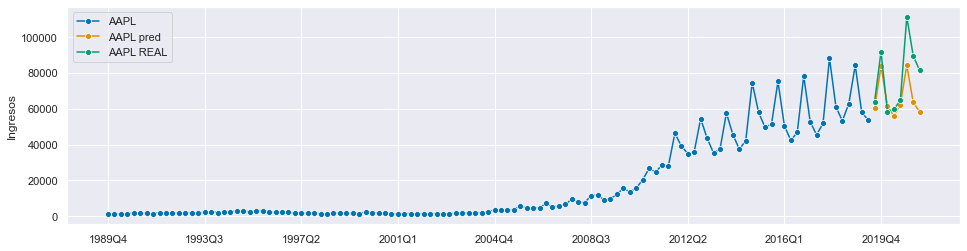

In [32]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(y_train, np.exp(log_y_pred),y_test, labels=["AAPL", 
                                                        "AAPL pred", 
                                                        "AAPL REAL"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

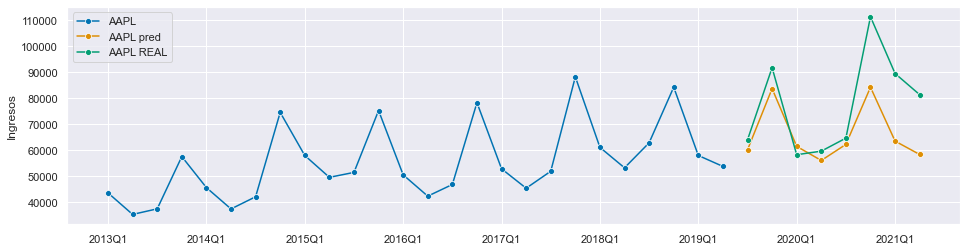

In [33]:
# Forecast Accuracy Plot
# Plotting predictions and past data
# Zoom 2013 -2021
plot_series(y_train["2013":], np.exp(log_y_pred),y_test, labels=["AAPL", 
                                                                 "AAPL pred", 
                                                                 "AAPL REAL"])

In [34]:
# Forecast Horizon
fh = np.arange(6) + 1  # forecasting horizon
fh

array([1, 2, 3, 4, 5, 6])

In [35]:
forecaster = AutoARIMA(sp=4,suppress_warnings=True)
forecaster.fit(log_aapl_ts)

AutoARIMA(sp=4, suppress_warnings=True)

In [36]:
print(forecaster.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  127
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 4)   Log Likelihood                  64.267
Date:                             Tue, 02 Nov 2021   AIC                           -118.534
Time:                                     11:47:25   BIC                           -104.352
Sample:                                          0   HQIC                          -112.772
                                             - 127                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3231      0.079     -4.096      0.000      -0.478      -0.169
ar.L2         -0.1574      

In [37]:
# SARIMAX(2, 1, 0)x(1, 0, [1], 4)
#  Auto ARIMA Forecast
log_y_pred = forecaster.predict(fh)
log_y_pred

2021Q3    11.406406
2021Q4    11.810568
2022Q1    11.532836
2022Q2    11.470475
2022Q3    11.565884
2022Q4    11.939248
Freq: Q-DEC, dtype: float64

In [38]:
np.exp(log_y_pred)

2021Q3     89895.737248
2021Q4    134668.014763
2022Q1    102010.974911
2022Q2     95843.778810
2022Q3    105438.562356
2022Q4    153161.525418
Freq: Q-DEC, dtype: float64

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

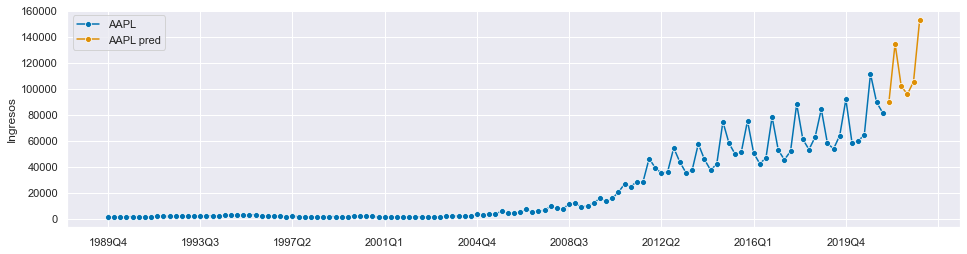

In [39]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(aapl_ts_q, np.exp(log_y_pred), labels=["AAPL", "AAPL pred"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Ingresos'>)

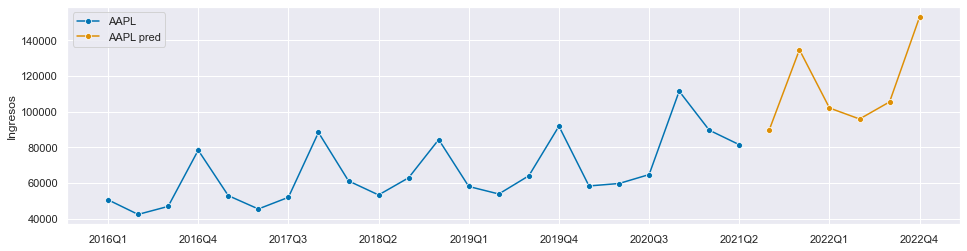

In [40]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(aapl_ts_q["2016":], np.exp(log_y_pred), labels=["AAPL", "AAPL pred"])